In [5]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
print(project_root)
if project_root not in sys.path:
    sys.path.append(project_root)


c:\Users\Camille\Documents\TWR


In [6]:
import nest_asyncio
nest_asyncio.apply()

from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.tools import tool
from utils import show_prompt, format_messages
from app.agents.prompts.deep_router_prompt import DEEP_ROUTER_PROMPT
from app.agents.prompts.system_rules import SYSTEM_RULES

In [7]:
from dotenv import load_dotenv
load_dotenv(".env", override=True)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
show_prompt(DEEP_ROUTER_PROMPT)
show_prompt(SYSTEM_RULES)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│  You are a Deep Routing Agent.                                                                                  │
│                                                                                                                 │
│  Your goal:                                                                                                     │
│  Decide which data source must be queried first to retrieve campaign requests                                   │
│  for further analysis.                                                                                          │
│                                                                                                                 │
│  Available tools:                                                                                               │
│  1. query_sql_campaigns                                                                                         │
│     - Use when the user provides a traffic source                                                               │
│     - Returns a list of campaign hashes                                                                         │
│                                                                                                                 │
│  2. query_mongo_requests                                                                                        │
│     - Use when the user provides a campaign hash                                                                │
│     - Use only after SQL if hashes come from traffic source                                                     │
│                                                                                                                 │
│  Rules:                                                                                                         │
│  - If the user provides a campaign hash, query MongoDB directly                                                 │
│  - If the user provides a traffic source, query SQL first                                                       │
│  - Never query MongoDB without at least one hash                                                                │
│  - Never query SQL if a hash is already provided                                                                │
│  - MongoDB queries must always be the final step                                                                │
│  - Do not analyze data, only retrieve it                                                                        │
│                                                                                                                 │
│  Think step by step and produce a clear execution plan.                                                         │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│  Hard rules:                                                                                                    │
│  - Never invent hashes or traffic sources                                                                       │
│  - Never assume missing information                                                                             │
│  - If the user request is unclear, ask for clarification                                                        │
│  - Do not explain your reasoning to the user                                                                    │
│  - Do not perform analysis or conclusions                                                                       │
│  - Only plan tool execution                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

### Setting llm model

### Importing the tools

In [10]:
from app.tools.data_tools import query_mongo_requests, query_sql_campaigns

tools = [query_sql_campaigns, query_mongo_requests]

In [12]:
await query_sql_campaigns.ainvoke(
    {"traffic_source": "google"}
)

['7jo72t2j87',
 'qxb9trhnbq',
 '0frtase63s',
 '1mjrezei1d',
 'pja3gn23kd',
 '8du0jij21k',
 'vjgewtbi20',
 '0zq3byqr08',
 '9symhqv1fn',
 '23zekzhu19']

In [13]:
from app.tools.data_tools import query_mongo_requests

await query_mongo_requests.ainvoke(
    {"hash": "i5986uszqq"}
)

[{'_id': ObjectId('698b6540a265b281ec4a18aa'),
  'datetime': datetime.datetime(2026, 2, 10, 17, 5, 4),
  'decision': 'bots',
  'headers': '{"Host":"wcb.conexespsimples.online","X-Request-Id":"f0673b2c75ae21a91df7998dfb03a0b0","X-Real-Ip":"131.196.110.148","X-Forwarded-For":"131.196.110.148","X-Forwarded-Host":"wcb.conexespsimples.online","X-Forwarded-Port":"80","X-Forwarded-Proto":"http","X-Forwarded-Scheme":"http","X-Scheme":"http","X-Original-Forwarded-For":"131.196.110.148, 172.71.234.185","Forwarded":"for=172.71.234.185","Sec-Fetch-Dest":"empty","Referer":"https:\\/\\/conexespsimples.online\\/","Priority":"u=1, i","Accept-Language":"pt-BR,pt;q=0.9,en-US;q=0.8,en;q=0.7","Cf-Ray":"9cbd306e8cae3236-GRU","Accept-Encoding":"gzip, br","Sec-Ch-Ua-Platform":"\\"macOS\\"","User-Agent":"Mozilla\\/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit\\/537.36 (KHTML, like Gecko) Chrome\\/141.0.0.0 Safari\\/537.36","Sec-Ch-Ua":"\\"Google Chrome\\";v=\\"141\\", \\"Not?A_Brand\\";v=\\"8\\", \\"Chr

### Agente

### sub-agents

In [25]:
from deepagents import create_deep_agent
from app.tools.data_tools import query_mongo_requests, query_sql_campaigns
from app.tools.ml_tool import *
from app.agents.prompts.ml_analist_prompt import SUBAGENT_DELEGATION_INSTRUCTIONS, ML_WORKFLOW_INSTRUCTIONS
from app.agents.ml_analyst_agent import ml_analyst_agent
from langchain_google_genai import ChatGoogleGenerativeAI

In [32]:
from app.agents.prompts.ml_analist_prompt import ML_ANALYST_INSTRUCTIONS
from utils import show_prompt


model = ChatGoogleGenerativeAI(
      model="gemini-2.5-flash",
      temperature=0
)
# Combine orchestrator instructions (RESEARCHER_INSTRUCTIONS only for sub-agents)
INSTRUCTIONS = (
    ML_WORKFLOW_INSTRUCTIONS
    + "\n\n"
    + "=" * 80
    + "\n\n"
    +  SUBAGENT_DELEGATION_INSTRUCTIONS
)


ml_analyst_tools = [
    summarize_misclassifications,
    find_low_trust_samples,
    analyze_user_agent_patterns,
    plot_ml_diagnostics,
    plot_risk_score_distribution,
]

orchestrator_tools = [
    query_sql_campaigns,
    query_mongo_requests,
    run_ml_inference,
    run_ml_noise_analysis,
    prepare_ml_dataframe,
]

ml_analyst_agent = {
    "name": "ml-analyst-agent",
    "description": (
        "Analyze and interpret machine learning inference results. "
        "This sub-agent explains model behavior, investigates misclassifications "
        "and noisy samples, identifies risk patterns in HTTP requests, "
        "and produces evidence-based insights for decision-making. "
        "It focuses on reasoning and analysis, not model training."
    ),
    "system_prompt": ML_ANALYST_INSTRUCTIONS,
    "tools": ml_analyst_tools,
}


agent = create_deep_agent(
      model=model,
      tools=orchestrator_tools,
      system_prompt=INSTRUCTIONS,
      subagents=[ml_analyst_agent]
)

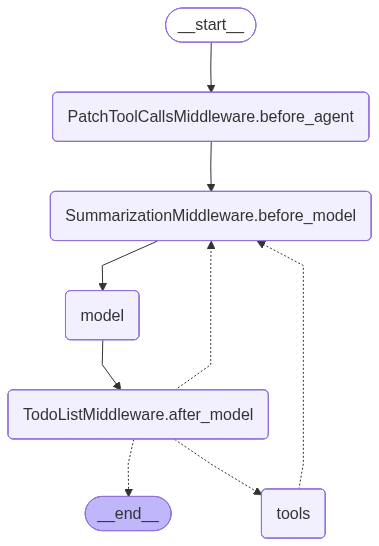

In [34]:
from IPython.display import Image, display


display(Image(agent.get_graph().draw_mermaid_png()))

In [35]:
result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": (
                    "Analyze recent HTTP requests for traffic_source 'google'. "
                    "Fetch the most recent active campaigns, load their request logs, "
                    "run the existing ML model for this traffic source, "
                    "and investigate misclassifications and noisy samples. "
                    "Focus on hidden bots (human-labeled but predicted as bot), "
                    "low mentor trust samples, and suspicious User-Agent patterns. "
                    "Provide a clear, evidence-based explanation of model behavior."
                ),
            }
        ],
    }
)

format_messages(result["messages"])


╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Analyze recent HTTP requests for traffic_source 'google'. Fetch the most recent active campaigns, load their    │
│ request logs, run the existing ML model for this traffic source, and investigate misclassifications and noisy   │
│ samples. Focus on hidden bots (human-labeled but predicted as bot), low mentor trust samples, and suspicious    │
│ User-Agent patterns. Provide a clear, evidence-based explanation of model behavior.                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯